In [1]:
import numpy as np
from scipy.spatial import ConvexHull
import timeit

# -----------------------
# Parameters (edit here)
# -----------------------
N = 100
M = 10
REPEAT = 5
NUMBER = 1000

# -----------------------
# Setup code
# -----------------------
setup_code = f"""
import numpy as np
from scipy.spatial import ConvexHull

N = {N}
M = {M}

points = np.random.rand(N, 2)
test_points = np.random.rand(M, 2)

hull = ConvexHull(points)

def points_in_hull(points, hull, tol=1e-12):
    A = hull.equations[:, :2]
    b = hull.equations[:, 2]
    return np.all(points @ A.T + b <= tol, axis=1)
"""

# -----------------------
# Benchmark hull creation
# -----------------------
hull_time = timeit.repeat(
    stmt="ConvexHull(points)",
    setup=setup_code,
    repeat=REPEAT,
    number=NUMBER
)

# -----------------------
# Benchmark membership checks
# -----------------------
membership_time = timeit.repeat(
    stmt="points_in_hull(test_points, hull)",
    setup=setup_code,
    repeat=REPEAT,
    number=NUMBER
)

print(f"N = {N}, M = {M}")
print()
print("ConvexHull creation:")
print(f"  best   : {min(hull_time)/NUMBER*1e6:.2f} µs per call")
print(f"  avg    : {np.mean(hull_time)/NUMBER*1e6:.2f} µs per call")
print()
print("Membership check (vectorized M points):")
print(f"  best   : {min(membership_time)/NUMBER*1e6:.2f} µs per call")
print(f"  avg    : {np.mean(membership_time)/NUMBER*1e6:.2f} µs per call")


N = 100, M = 10

ConvexHull creation:
  best   : 421.53 µs per call
  avg    : 438.62 µs per call

Membership check (vectorized M points):
  best   : 4.63 µs per call
  avg    : 4.88 µs per call


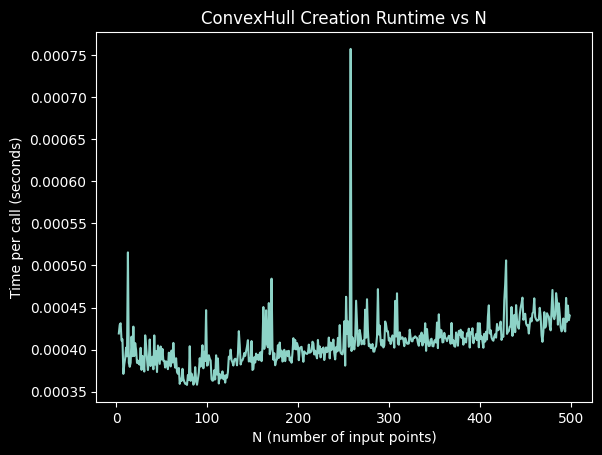

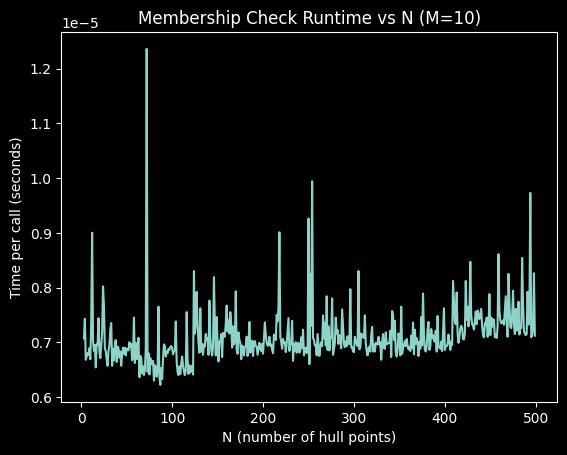

In [2]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# -----------------------
# Parameters
# -----------------------
Ns = np.arange(3, 500)
M = 10
REPEAT = 3
NUMBER = 10

hull_times = []
membership_times = []

for N in Ns:
    setup_code = f"""
import numpy as np
from scipy.spatial import ConvexHull

N = {N}
M = {M}

points = np.random.rand(N, 2)
test_points = np.random.rand(M, 2)

hull = ConvexHull(points)

def points_in_hull(points, hull, tol=1e-12):
    A = hull.equations[:, :2]
    b = hull.equations[:, 2]
    return np.all(points @ A.T + b <= tol, axis=1)
"""

    # Hull creation timing
    hull_time = timeit.repeat(
        stmt="ConvexHull(points)",
        setup=setup_code,
        repeat=REPEAT,
        number=NUMBER
    )
    hull_times.append(min(hull_time) / NUMBER)

    # Membership timing
    membership_time = timeit.repeat(
        stmt="points_in_hull(test_points, hull)",
        setup=setup_code,
        repeat=REPEAT,
        number=NUMBER
    )
    membership_times.append(min(membership_time) / NUMBER)

hull_times = np.array(hull_times)
membership_times = np.array(membership_times)

# -----------------------
# Plot: Hull Creation
# -----------------------
plt.figure()
plt.plot(Ns, hull_times)
plt.xlabel("N (number of input points)")
plt.ylabel("Time per call (seconds)")
plt.title("ConvexHull Creation Runtime vs N")
plt.show()

# -----------------------
# Plot: Membership Checks
# -----------------------
plt.figure()
plt.plot(Ns, membership_times)
plt.xlabel("N (number of hull points)")
plt.ylabel("Time per call (seconds)")
plt.title(f"Membership Check Runtime vs N (M={M})")
plt.show()


In [4]:
import numpy as np
from scipy.spatial import ConvexHull

def hull_mask2d(hull, shape):
    ny, nx = shape
    eq = hull.equations
    A = eq[:, :2]
    b = eq[:, 2]
    pts = hull.points[hull.vertices]
    mn = np.floor(pts.min(0)).astype(int)
    mx = np.ceil(pts.max(0)).astype(int)
    x0 = 0 if mn[0] < 0 else mn[0]
    y0 = 0 if mn[1] < 0 else mn[1]
    x1 = nx-1 if mx[0] >= nx else mx[0]
    y1 = ny-1 if mx[1] >= ny else mx[1]
    m = np.zeros((ny, nx), np.uint8)
    if x1 < x0 or y1 < y0:
        return m
    X, Y = np.meshgrid(np.arange(x0, x1+1, dtype=np.float64),
                       np.arange(y0, y1+1, dtype=np.float64), indexing="xy")
    P = np.stack((X.ravel(), Y.ravel()), 1)
    inside = np.all((A @ P.T + b[:, None]) <= 1e-12, 0)
    m[y0:y1+1, x0:x1+1] = inside.reshape((y1-y0+1, x1-x0+1))
    return m

ny, nx = 100, 100
shape = (ny, nx)

rng = np.random.default_rng(0)
center = np.array([nx/2, ny/2], dtype=float)
angles = np.sort(rng.uniform(0, 2*np.pi, 200))
r = rng.uniform(10, 35, 200)
cloud = center + np.c_[np.cos(angles), np.sin(angles)] * r[:, None] + rng.normal(0, 2.0, (200, 2))
cloud = np.clip(cloud, [0, 0], [nx-1, ny-1])
hull = ConvexHull(cloud)

m = hull_mask2d(hull, shape)
assert m.shape == shape and m.dtype == np.uint8

%timeit hull_mask2d(hull, shape)

111 μs ± 4.69 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
